Hidden units regions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from model import ShallowNeuralNetwork

def hidden_unit_linear_regions(hidden_unit, phi, axes, titles, color):
    ax1, ax2, ax3 = axes
    linear_func  = lambda x: hidden_unit.theta0 + hidden_unit.theta1 * x

    for ax in axes:
        ax.plot([0,2], [0,0], color="#abb2b9", linestyle="--")

    ax1.plot([0, 2], [linear_func(0), linear_func(2)], color=color)
    ax1.text(1., -0.85, titles[0], horizontalalignment='center',
             verticalalignment='center', color=color)
    ax2.text(1., -0.85, titles[1], horizontalalignment='center',
             verticalalignment='center', color=color)
    ax3.text(1., -0.85, titles[2], horizontalalignment='center',
             verticalalignment='center', color=color)

    t = np.linspace(0,2,50)
    ax2.plot(t, [hidden_unit(x) for x in t], color=color)
    ax3.plot(t, [phi*hidden_unit(x) for x in t], color=color)


phi_1 =  0.2
phi_2 = -0.8
phi_3 =  0.7
phi_4 =  0.4
h_1: Hidden Unit: (-0.2,  0.3)
h_2: Hidden Unit: (-0.9,  0.8)
h_3: Hidden Unit: ( 1.0, -0.6)


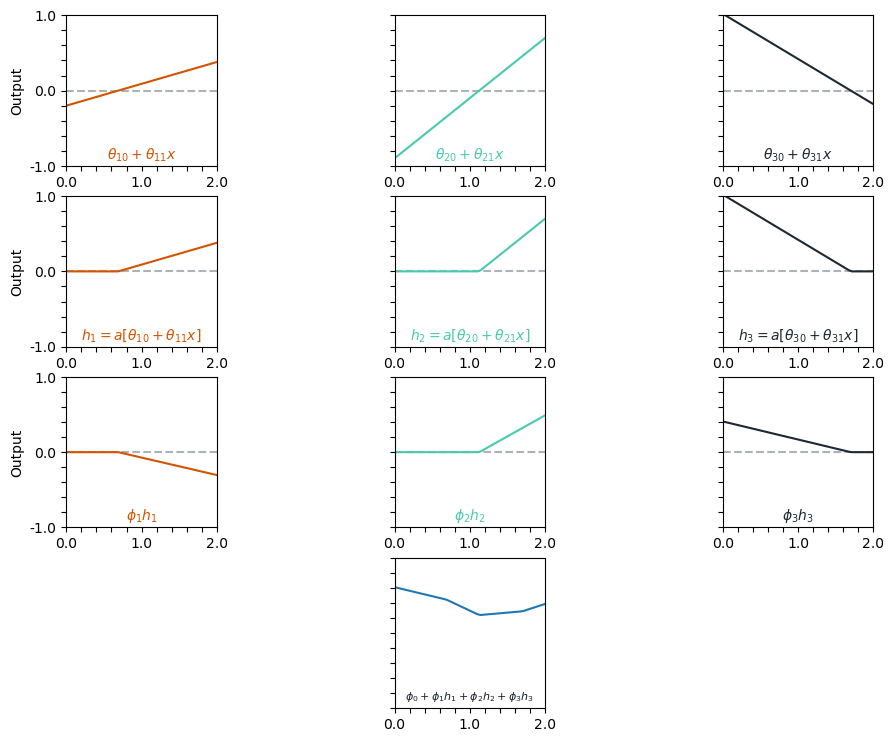

In [2]:
neural_network = ShallowNeuralNetwork(params=[0.2, -0.8, 0.7, 0.4],
                                        hidden_units_params=[(-0.2, 0.29), (-0.9, 0.8), (1.02, -0.6)])

for i,p in enumerate(neural_network.params):
    print("phi_%d = %4.1f" % (i+1, p))

fig, axes = plt.subplots(4,3, figsize=(12, 9), dpi=100)

for i, (h,color) in enumerate(zip(neural_network.hidden_units, ["#d35400", "#48c9b0", "#1c2833"])):
    print(f"h_{i+1}:", h)
    titles = [rf"$\theta_{{{i+1}0}} + \theta_{{{i+1}1}} x$",
                rf"$h_{i+1} = a[\theta_{{{i+1}0}} + \theta_{{{i+1}1}} x]$",
                rf"$\phi_{i+1} h_{i+1}$"]
    hidden_unit_linear_regions(h, phi=neural_network.params[i+1],
                                axes=[axes[0,i], axes[1,i], axes[2,i]],
                                titles=titles,
                                color=color)
for i,ax in enumerate(axes.ravel()):
    ax.set_aspect('equal')
    ax.set_xlim([0, 2])
    ax.set_ylim([-1, 1])
    ax.set_xticks(ticks=np.arange(0,2.2,0.2), labels=["0.0"]+['']*4+["1.0"]+['']*4+["2.0"])
    if i%3==0:
        ax.set_yticks(ticks=np.arange(-1,1.2,0.2), labels=["-1.0"]+['']*4+["0.0"]+['']*4+["1.0"])
    else:
        ax.set_yticks(ticks=np.arange(-1,1.2,0.2), labels=['']*11)
    if i%3==0: ax.set_ylabel("Output")

axes[3,0].axis("off")
axes[3,2].axis("off")

t = np.linspace(0,2,50)
axes[3,1].plot(t, [neural_network(x) for x in t])
axes[3,1].text(1., -0.85, r"$\phi_0 + \phi_1 h_1 + \phi_2 h_2 + \phi_3 h_3$", horizontalalignment='center',
            verticalalignment='center', color="#17202a", fontsize=8)

plt.show()

Implementation from scratch

In [3]:
import torch

class LinearDataset(torch.utils.data.Dataset):
    def __init__(self, w, b, n, noise=0.01):
        self.w = w
        self.b = b
        noise = noise * torch.randn(n, 1)
        self.X = torch.randn(n, len(w))
        self.y = torch.matmul(self.X, w.reshape(-1,1)) + b + noise
    
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

    def __len__(self): return len(self.X)

In [4]:
class LinearModel:
    def __init__(self, num_inputs):
        self.w = torch.normal(mean=0., std=0.01, size=(num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

    def forward(self, x):
        return torch.matmul(x, self.w) + self.b

    def __call__(self, x): return self.forward(x)

In [5]:
class SGD:
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr
    
    def step(self):
        for p in self.params:
            p -= self.lr * p.grad

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

In [6]:
def train(model, criterion, data, epochs, optimizer, metrics=None):
    track_loss = []
    if metrics is not None:
        track_metrics = {m.__name__: [] for m in metrics}
    for i in range(epochs):
        epoch_loss = 0
        if metrics is not None:
            epoch_metrics = {m.__name__: 0 for m in metrics}
        for batch in data:
            y_pred = model(*batch[:-1])
            y_true = batch[-1]
            loss = criterion(y_pred, y_true)
            optimizer.zero_grad()
            loss.backward()
            with torch.no_grad():
                optimizer.step()
            epoch_loss += loss.item()
            if metrics is not None:
                for m in metrics:
                    epoch_metrics[m.__name__] += m(y_pred=y_pred, y_true=y_true)

        epoch_loss /= len(data)
        track_loss.append(epoch_loss)
        if metrics is not None:
            for m in metrics:
                epoch_metrics[m.__name__] /= len(data)
                track_metrics[m.__name__].append(epoch_metrics[m.__name__])
        summary = "Epoch: %d, loss: %.4f" % (i+1, epoch_loss)
        if metrics is not None:
            summary += ", " + ", ".join(["%s: %.4f" % (k,v) for k,v in epoch_metrics.items()])
        print(summary)
    plt.plot(track_loss); plt.title("loss"); plt.show()
    if metrics is not None:
        for name, values in track_metrics.items():
            plt.plot(values); plt.title(name); plt.show()


num of batches:  63
Params to estimate are:
w: tensor([1.3000, 0.6000]) , b: tensor([4.9000])
Before training:
w: [[-4.6837325e-05]
 [-5.5756699e-03]] , b: 0.0
Epoch: 1, loss: 7.5296
Epoch: 2, loss: 2.0809
Epoch: 3, loss: 0.5728
Epoch: 4, loss: 0.1591
Epoch: 5, loss: 0.0443
Epoch: 6, loss: 0.0124
Epoch: 7, loss: 0.0035
Epoch: 8, loss: 0.0010
Epoch: 9, loss: 0.0003
Epoch: 10, loss: 0.0001


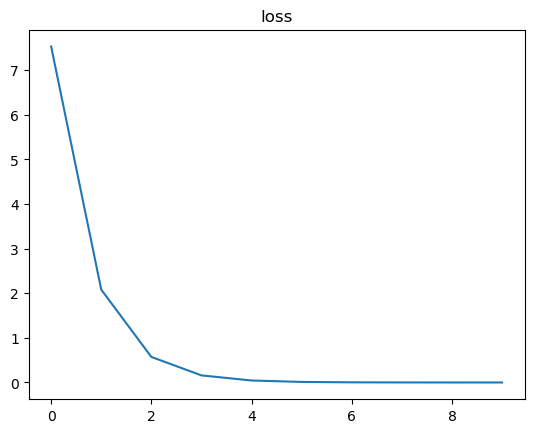

After training
w: [[1.2986232]
 [0.6003868]] , b: 4.891740322113037


In [7]:
data = LinearDataset(w=torch.tensor([1.3, 0.6]),
                        b=torch.tensor([4.9]), n=1000, noise=0.01)
dataloader = torch.utils.data.DataLoader(dataset=data, shuffle=True, batch_size=16, num_workers=4)
print("num of batches: ", len(dataloader))
model = LinearModel(num_inputs=2)
optimizer = SGD(params=[model.w, model.b], lr=0.01)
criterion = lambda x,y: ((x-y)**2 / 2).mean()

print("Params to estimate are:")
print("w:", dataloader.dataset.w, ", b:", dataloader.dataset.b)
print("Before training:")
print("w:", model.w.detach().numpy(), ", b:", model.b.item())
train(model=model, data=dataloader, criterion=criterion, optimizer=optimizer, epochs=10)
print("After training")
print("w:", model.w.detach().numpy(), ", b:", model.b.item())

Concise implementation

In [8]:
import torch
import torch.nn as nn
class ConciseLinearModel(nn.Module):
    def __init__(self, input_size: int, output_size: int, init=True):
        super().__init__()
        self.net = nn.Linear(in_features=input_size, out_features=output_size)
        if init:
            self.net.bias.data.fill_(0)
            self.net.weight.data.normal_(mean=0, std=1)
    def forward(self, x): return self.net(x)

In [9]:
model = ConciseLinearModel(input_size=2, output_size=1, init=False)
print("Bias:", model.net.bias)
print("Weight:", model.net.weight)
model.net.bias.data.fill_(0)
model.net.weight.data.normal_(mean=0, std=1)
print("Bias:", model.net.bias)
print("Weight:", model.net.weight)

Bias: Parameter containing:
tensor([0.7005], requires_grad=True)
Weight: Parameter containing:
tensor([[-0.5625, -0.6376]], requires_grad=True)
Bias: Parameter containing:
tensor([0.], requires_grad=True)
Weight: Parameter containing:
tensor([[-1.5328,  0.2158]], requires_grad=True)


In [10]:
def train2(model, criterion, data, epochs, optimizer, metrics=None):
    track_loss = []
    if metrics is not None:
        track_metrics = {m.__name__: [] for m in metrics}
    for i in range(epochs):
        epoch_loss = 0
        if metrics is not None:
            epoch_metrics = {m.__name__: 0 for m in metrics}
        for batch in data:
            y_pred = model(*batch[:-1])
            y_true = batch[-1]
            loss = criterion(y_pred, y_true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            if metrics is not None:
                for m in metrics:
                    epoch_metrics[m.__name__] += m(y_pred=y_pred, y_true=y_true)

        epoch_loss /= len(data)
        track_loss.append(epoch_loss)
        if metrics is not None:
            for m in metrics:
                epoch_metrics[m.__name__] /= len(data)
                track_metrics[m.__name__].append(epoch_metrics[m.__name__])
        summary = "Epoch: %d, loss: %.4f" % (i+1, epoch_loss)
        if metrics is not None:
            summary += ", " + ", ".join(["%s: %.4f" % (k,v) for k,v in epoch_metrics.items()])
        print(summary)
    plt.plot(track_loss); plt.title("loss"); plt.show()
    if metrics is not None:
        for name, values in track_metrics.items():
            plt.plot(values); plt.title(name); plt.show()


Params to estimate are:
w: tensor([ 2.3000, -2.3000]) , b: tensor([-8])
Before training:
w: [[-0.09971831  1.9729352 ]] , b: 0.0
Epoch: 1, loss: 32.3236
Epoch: 2, loss: 2.7401
Epoch: 3, loss: 0.2407
Epoch: 4, loss: 0.0213
Epoch: 5, loss: 0.0020
Epoch: 6, loss: 0.0003
Epoch: 7, loss: 0.0001
Epoch: 8, loss: 0.0001
Epoch: 9, loss: 0.0001
Epoch: 10, loss: 0.0001


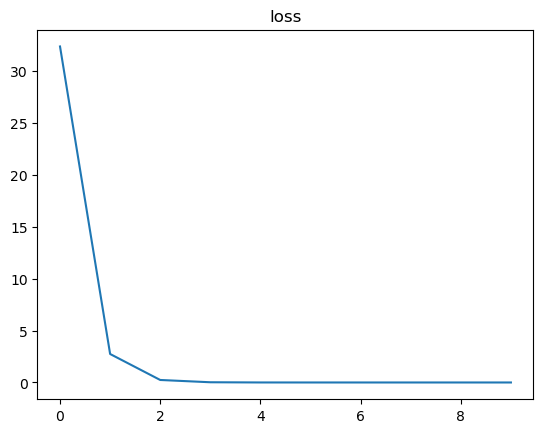

After training
w: [[ 2.29979   -2.2991414]] , b: -8.000349998474121


In [11]:
data = LinearDataset(w=torch.tensor([2.3, -2.3]),
                        b=torch.tensor([-8]), n=1000, noise=0.01)
dataloader = torch.utils.data.DataLoader(dataset=data, shuffle=True, batch_size=16, num_workers=4)
model = ConciseLinearModel(input_size=2, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
print("Params to estimate are:")
print("w:", dataloader.dataset.w, ", b:", dataloader.dataset.b)
print("Before training:")
print("w:", model.net.weight.data.detach().numpy(), ", b:", model.net.bias.data.item())
train2(model=model, data=dataloader, criterion=criterion, optimizer=optimizer, epochs=10)
print("After training")
print("w:", model.net.weight.data.detach().numpy(), ", b:", model.net.bias.data.item())

Classification

In [12]:
import torchvision
import torchvision.transforms as transforms

class FashionMnist:
    def __init__(self, root="datasets", batch_size=16, resize=(28,28)):
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        train = torchvision.datasets.FashionMNIST(
            root=root, train=True, download=True, transform=trans
        )
        self.train = torch.utils.data.DataLoader(
            dataset=train, shuffle=True, batch_size=batch_size, num_workers=4
        )

In [13]:
data = FashionMnist(batch_size=4).train
print(len(data))
print(data.dataset)
print(len(data.dataset))

15000
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
60000


tensor(1)
tensor(6)
tensor(7)
tensor(8)


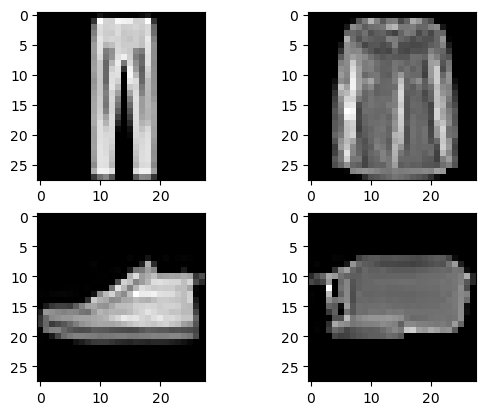

In [14]:
fig, axes = plt.subplots(2,2)
axes = axes.ravel()
for batch in data:
    imgs, labels = batch
    for i,img in enumerate(imgs):
        print(labels[i])
        axes[i].imshow(img.reshape(28,28), cmap="gray")
    break
plt.show()

In [15]:
def accuracy(y_pred, y_true, averaged=True):
    y_pred = y_pred.reshape((-1, y_pred.shape[-1]))
    preds = y_pred.argmax(axis=-1).type(y_true.dtype)
    compare = (preds==y_true.reshape(-1)).type(torch.float32)
    return compare.mean() if averaged else compare

accuracy(torch.tensor([[0.9,0.1,0.1], [0.1,0.9,0.1], [0.9,0.1,0.1]]), torch.tensor([0,1,0]))

tensor(1.)

In [16]:
x = torch.tensor([[1., 2., 3.], [4., 5., 6.]])
print(x)
x.sum(axis=0, keepdims=True), x.sum(axis=1, keepdims=True)

tensor([[1., 2., 3.],
        [4., 5., 6.]])


(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [17]:
def softmax(x):
    x_exp = torch.exp(x)
    partition = x_exp.sum(axis=1, keepdims=True)
    return x_exp / partition

In [18]:
x = torch.rand((2,5))
print(x)
probs = softmax(x)
probs, probs.sum(axis=1)

tensor([[0.8461, 0.6256, 0.5246, 0.9135, 0.9010],
        [0.0305, 0.7496, 0.0675, 0.4087, 0.2817]])


(tensor([[0.2149, 0.1724, 0.1558, 0.2299, 0.2270],
         [0.1463, 0.3003, 0.1518, 0.2136, 0.1881]]),
 tensor([1.0000, 1.0000]))

In [19]:
class SoftmaxRegressionScratch:
    def __init__(self, num_inputs, num_outputs):
        self.w = torch.normal(mean=0, std=0.01, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)
    
    def forward(self, *x):
        if isinstance(x, tuple): x = x[0]
        x = x.reshape((-1, self.w.shape[0]))
        return softmax(torch.matmul(x, self.w) + self.b)

    def __call__(self, x): return self.forward(x)

    def parameters(self): return [self.w, self.b]

In [20]:
model = SoftmaxRegressionScratch(num_inputs=28*28, num_outputs=10)
for batch in data:
    y_pred = model(*batch[:-1])
    print(y_pred)
    break

tensor([[0.1087, 0.0830, 0.0715, 0.1126, 0.1168, 0.1036, 0.0894, 0.1045, 0.1030,
         0.1068],
        [0.1017, 0.0886, 0.0723, 0.1124, 0.1106, 0.1108, 0.0930, 0.0929, 0.1105,
         0.1070],
        [0.0987, 0.0916, 0.0890, 0.1056, 0.0970, 0.1193, 0.0930, 0.1000, 0.1016,
         0.1043],
        [0.1004, 0.1036, 0.1039, 0.1037, 0.0981, 0.0946, 0.1047, 0.0901, 0.0987,
         0.1021]], grad_fn=<DivBackward0>)


In [21]:
y_true = torch.tensor([0,2, 1])
y_pred = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5], [0.3, 0.2, 0.5]])
y_pred[[0,1,2], y_true]

tensor([0.1000, 0.5000, 0.2000])

In [22]:
def cross_entropy(y_pred, y_true):
    return -torch.log(y_pred[list(range(len(y_true))), y_true]).mean()

In [23]:
cross_entropy(y_pred,y_true)

tensor(1.5351)

Epoch: 1, loss: 0.7873, accuracy: 0.7473
Epoch: 2, loss: 0.5706, accuracy: 0.8124
Epoch: 3, loss: 0.5268, accuracy: 0.8252
Epoch: 4, loss: 0.5013, accuracy: 0.8317
Epoch: 5, loss: 0.4860, accuracy: 0.8368
Epoch: 6, loss: 0.4739, accuracy: 0.8404
Epoch: 7, loss: 0.4642, accuracy: 0.8427
Epoch: 8, loss: 0.4581, accuracy: 0.8444
Epoch: 9, loss: 0.4519, accuracy: 0.8461
Epoch: 10, loss: 0.4472, accuracy: 0.8478


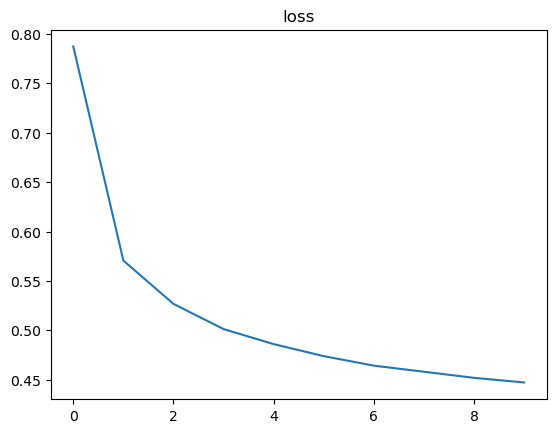

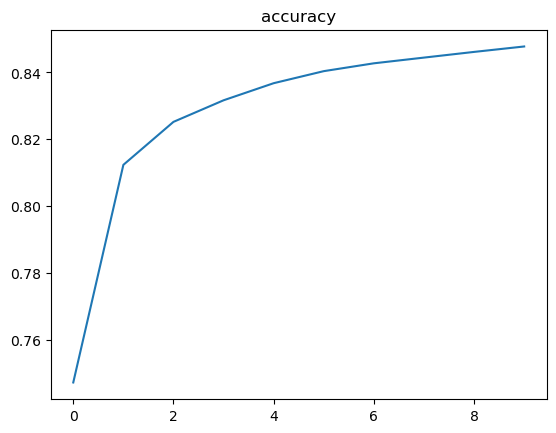

In [24]:
model = SoftmaxRegressionScratch(num_inputs=28*28, num_outputs=10)
dataloader = FashionMnist(batch_size=256).train
criterion = cross_entropy
epochs=10
optimizer = SGD(model.parameters(), 0.1)
train(model=model, data=dataloader, criterion=criterion, optimizer=optimizer, epochs=10, metrics=[accuracy])


Concise classification model

In [25]:
class ConciseSoftmaxRegression(nn.Module):
    def __init__(self, num_inputs: int, num_outputs: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=num_inputs, out_features=num_outputs)
        )
    def forward(self, x):
        return self.net(x)

In [26]:
import torch.nn.functional as F
y_true = torch.tensor([0,2, 1], dtype=torch.int64)
y_pred = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5], [0.3, 0.2, 0.5]])
y_pred[[0,1,2], y_true]
F.cross_entropy(input=y_pred, target=y_true,
                reduction="mean")

tensor(1.1776)

Epoch: 1, loss: 0.7874, accuracy: 0.7474
Epoch: 2, loss: 0.5696, accuracy: 0.8135
Epoch: 3, loss: 0.5261, accuracy: 0.8262
Epoch: 4, loss: 0.5020, accuracy: 0.8326
Epoch: 5, loss: 0.4848, accuracy: 0.8373
Epoch: 6, loss: 0.4740, accuracy: 0.8400
Epoch: 7, loss: 0.4654, accuracy: 0.8427
Epoch: 8, loss: 0.4583, accuracy: 0.8449
Epoch: 9, loss: 0.4523, accuracy: 0.8461
Epoch: 10, loss: 0.4474, accuracy: 0.8479


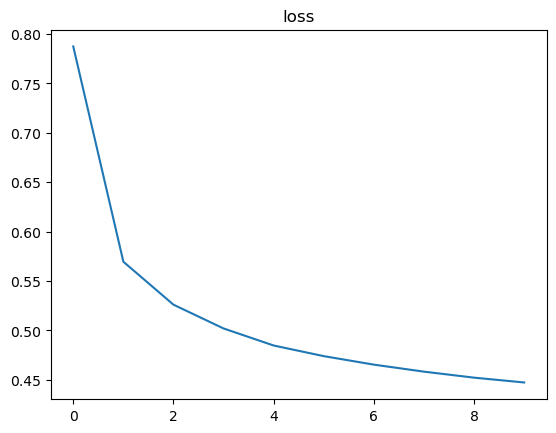

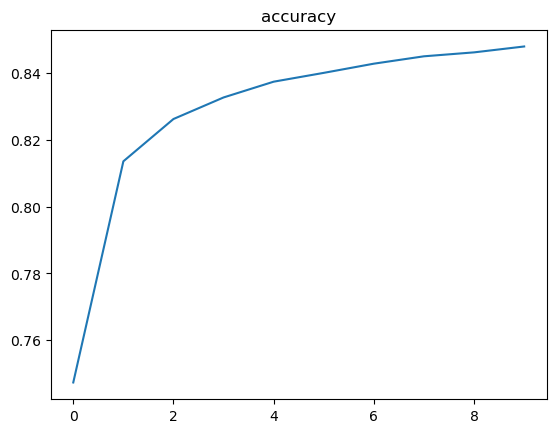

In [27]:
model = ConciseSoftmaxRegression(num_inputs=28*28, num_outputs=10)
dataloader = FashionMnist(batch_size=256).train
criterion = F.cross_entropy
epochs=10
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
train2(model=model, data=dataloader, criterion=criterion, optimizer=optimizer, epochs=10, metrics=[accuracy])

Multilayer Perceptrons (MLPs)

In [28]:
def relu(x):
    a = torch.zeros_like(x)
    return torch.max(x, a)

class MLPScratch:
    def __init__(self, num_inputs: int, num_outputs: int, num_hiddens: int):
        self.W1 = nn.Parameter(data=torch.randn(size=(num_inputs, num_hiddens)) * 0.01)
        self.b1 = nn.Parameter(data=torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(data=torch.randn(size=(num_hiddens, num_outputs)) * 0.01, requires_grad=True)
        self.b2 = nn.Parameter(data=torch.zeros(num_outputs), requires_grad=True)
    
    def forward(self, x):
        if isinstance(x, tuple): x = x[0]
        x = x.reshape((-1, self.W1.shape[0]))
        H = relu(torch.matmul(x, self.W1) + self.b1)
        return torch.matmul(H, self.W2) + self.b2
    
    def __call__(self, x): return self.forward(x)

    def parameters(self): return [self.W1, self.b1, self.W2, self.b2]

Epoch: 1, loss: 2.1632, accuracy: 0.2856
Epoch: 2, loss: 1.5426, accuracy: 0.5650
Epoch: 3, loss: 1.1297, accuracy: 0.6332
Epoch: 4, loss: 0.9444, accuracy: 0.6660
Epoch: 5, loss: 0.8465, accuracy: 0.6869
Epoch: 6, loss: 0.7851, accuracy: 0.7096
Epoch: 7, loss: 0.7408, accuracy: 0.7318
Epoch: 8, loss: 0.7058, accuracy: 0.7484
Epoch: 9, loss: 0.6755, accuracy: 0.7634
Epoch: 10, loss: 0.6492, accuracy: 0.7762


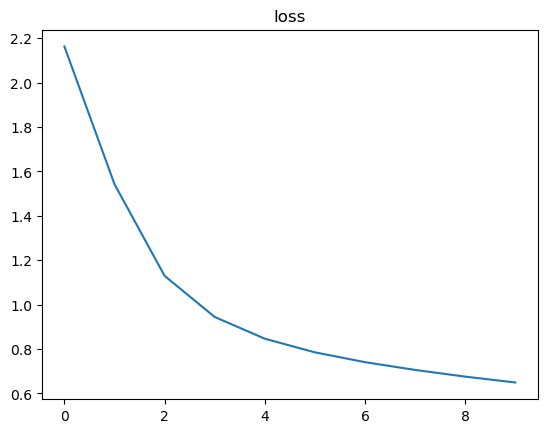

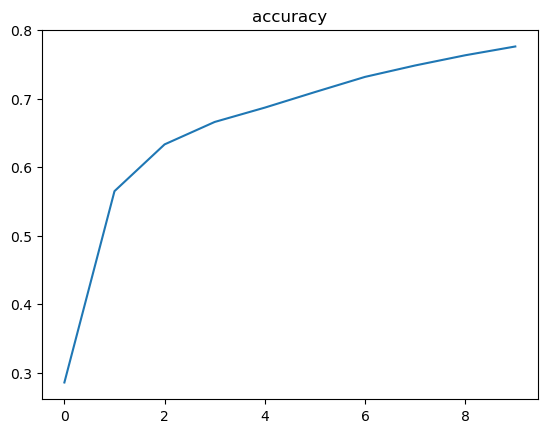

In [29]:
model = MLPScratch(num_inputs=28*28, num_outputs=10, num_hiddens=256)
dataloader = FashionMnist(batch_size=256).train
# criterion = cross_entropy
criterion = F.cross_entropy
epochs=10
optimizer = SGD(model.parameters(), 0.01)
train(model=model, data=dataloader, criterion=criterion, optimizer=optimizer, epochs=10, metrics=[accuracy])


In [30]:
class ConciseMLP(nn.Module):
    def __init__(self, num_inputs: int, num_outputs: int, num_hiddens: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=num_inputs, out_features=num_hiddens), nn.ReLU(),
            nn.Linear(in_features=num_hiddens, out_features=num_outputs),
        )

    def forward(self, x):
        return self.net(x)

ConciseMLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)
Epoch: 1, loss: 0.8635, accuracy: 0.7142
Epoch: 2, loss: 0.5573, accuracy: 0.8069
Epoch: 3, loss: 0.4942, accuracy: 0.8274
Epoch: 4, loss: 0.4600, accuracy: 0.8406
Epoch: 5, loss: 0.4343, accuracy: 0.8471
Epoch: 6, loss: 0.4179, accuracy: 0.8535
Epoch: 7, loss: 0.4018, accuracy: 0.8595
Epoch: 8, loss: 0.3880, accuracy: 0.8637
Epoch: 9, loss: 0.3784, accuracy: 0.8666
Epoch: 10, loss: 0.3685, accuracy: 0.8700


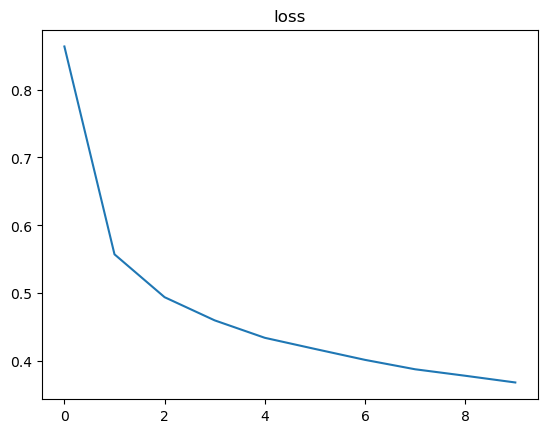

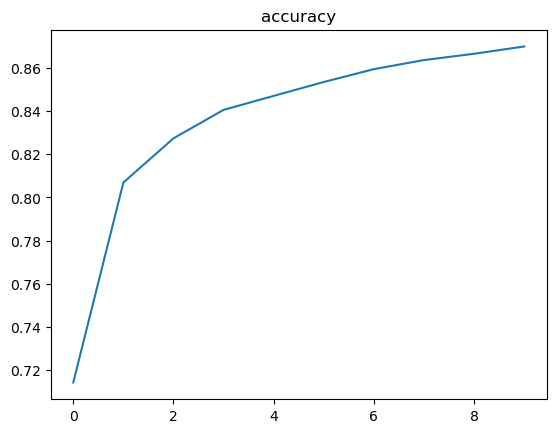

In [31]:
model = ConciseMLP(num_inputs=28*28, num_outputs=10, num_hiddens=256)
print(model)
dataloader = FashionMnist(batch_size=256).train
criterion = F.cross_entropy
epochs=10
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
train2(model=model, data=dataloader, criterion=criterion, optimizer=optimizer, epochs=10, metrics=[accuracy])